## Import packages

In [1]:
import numpy as np
from matplotlib import pyplot as plt, ticker as mticker
from matplotlib.patches import Ellipse
from mpl_toolkits.basemap import Basemap
import os
os.chdir('../pygiop/')
import pandas as pd
from scripts import pwIOP, phytoA, getChlor, getGiop

In [2]:
DATA_FOLDER = '/Users/erickson/Documents/Postdoc/Research/Bayes_GIOP/Valente_dataset/'

## Load data

In [3]:
fn_rrs = DATA_FOLDER+'insitudb_rrs_satbands6.csv'
db_rrs = pd.read_csv(fn_rrs)
fn_iop = DATA_FOLDER+'insitudb_iopskdtsm_satbands6_2019-06_corrected.csv'
db_iop = pd.read_csv(fn_iop)
fn_chl = DATA_FOLDER+'insitudb_chla.csv'
db_chl = pd.read_csv(fn_chl)

/Users/erickson/.conda/envs/zke/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3441: DtypeWarning: Columns (354,355,356) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [4]:
# print names of columns
for col in db_rrs.columns:
    print(col,end=', ')

idx, time, lat, lon, rrs_MER1, lam_MER1, rrs_MER2, lam_MER2, rrs_MER3, lam_MER3, rrs_MER4, lam_MER4, rrs_MER5, lam_MER5, rrs_MER6, lam_MER6, rrs_MER7, lam_MER7, rrs_MER8, lam_MER8, rrs_MER9, lam_MER9, rrs_MER10, lam_MER10, rrs_MER11, lam_MER11, rrs_MER12, lam_MER12, rrs_MER13, lam_MER13, rrs_MOD1, lam_MOD1, rrs_MOD2, lam_MOD2, rrs_MOD3, lam_MOD3, rrs_MOD4, lam_MOD4, rrs_MOD5, lam_MOD5, rrs_MOD6, lam_MOD6, rrs_MOD7, lam_MOD7, rrs_MOD8, lam_MOD8, rrs_MOD9, lam_MOD9, rrs_SWS1, lam_SWS1, rrs_SWS2, lam_SWS2, rrs_SWS3, lam_SWS3, rrs_SWS4, lam_SWS4, rrs_SWS5, lam_SWS5, rrs_SWS6, lam_SWS6, rrs_SWS7, lam_SWS7, rrs_SWS8, lam_SWS8, rrs_VIR1, lam_VIR1, rrs_VIR2, lam_VIR2, rrs_VIR3, lam_VIR3, rrs_VIR4, lam_VIR4, rrs_VIR5, lam_VIR5, rrs_OLC1, lam_OLC1, rrs_OLC2, lam_OLC2, rrs_OLC3, lam_OLC3, rrs_OLC4, lam_OLC4, rrs_OLC5, lam_OLC5, rrs_OLC6, lam_OLC6, rrs_OLC7, lam_OLC7, etopo1, rrs_dataset, rrs_subdataset, rrs_contributor, flag_time, 

In [5]:
wvs = np.array([411,443,488,510,555,670]) # this is for SeaWiFS
#wvs = np.array([411,443,488,531,547,667,678,750]) # this is for MODIS

In [6]:
lon = db_iop['lon'].to_numpy()
lat = db_iop['lat'].to_numpy()

### Find indices where all data are present (for SeaWiFS)


In [7]:
good_rrs_inds = np.all(np.array([np.isfinite(db_rrs['rrs_SWS%d'%i]) for i in range(1,7)]),axis=0)
good_aph_inds = np.all(np.array([np.isfinite(db_iop['aph_SWS%d'%i]) for i in range(1,7)]),axis=0)
good_adg_inds = np.all(np.array([np.isfinite(db_iop['adg_SWS%d'%i]) for i in range(1,7)]),axis=0)
good_bbp_inds = np.all(np.array([np.isfinite(db_iop['bbp_SWS%d'%i]) for i in range(1,7)]),axis=0)
good_iop_inds = good_aph_inds & good_adg_inds & good_bbp_inds
good_chl_inds = np.isfinite(db_chl['chla_fluor']) | np.isfinite(db_chl['chla_hplc'])

good_rrs_idx = db_rrs['idx'][good_rrs_inds].to_numpy()
good_iop_idx = db_iop['idx'][good_iop_inds].to_numpy()
good_chl_idx = db_chl['idx'][good_chl_inds].to_numpy()

all_idx = np.intersect1d(np.intersect1d(good_rrs_idx,good_iop_idx),good_chl_idx)
all_inds_rrs = np.where(good_rrs_inds)[0][np.isin(good_rrs_idx,all_idx)]
all_inds_iop = np.where(good_iop_inds)[0][np.isin(good_iop_idx,all_idx)]
all_inds_chl = np.where(good_chl_inds)[0][np.isin(good_chl_idx,all_idx)]

In [8]:
print('Num with all variables',len(all_idx))

Num with all variables 86


In [9]:
print('These are the datasets that had all variables')
print('Rrs datasets:',db_rrs['rrs_dataset'][all_inds_rrs].unique())
print('aph datasets:',db_iop['aph_dataset'][all_inds_iop].unique())
print('adg datasets:',db_iop['adg_dataset'][all_inds_iop].unique())
print('bbp datasets:',db_iop['bbp_dataset'][all_inds_iop].unique())
print('fchl datasets:',db_chl['chla_fluor_dataset'][all_inds_chl].unique())
print('HPLC datasets:',db_chl['chla_hplc_dataset'][all_inds_chl].unique())



These are the datasets that had all variables
Rrs datasets: ['nomad']
aph datasets: ['nomad']
adg datasets: ['nomad']
bbp datasets: ['nomad']
fchl datasets: ['nomad']
HPLC datasets: ['nomad' nan]


In [10]:
all_rrs = np.array([db_rrs['rrs_SWS%d'%i][all_inds_rrs] for i in range(1,7)])
all_aph = np.array([db_iop['aph_SWS%d'%i][all_inds_iop] for i in range(1,7)])
all_adg = np.array([db_iop['adg_SWS%d'%i][all_inds_iop] for i in range(1,7)])
all_bbp = np.array([db_iop['bbp_SWS%d'%i][all_inds_iop] for i in range(1,7)])

all_lon = db_iop['lon'][all_inds_iop].to_numpy()
all_lat = db_iop['lat'][all_inds_iop].to_numpy()

all_chlf = db_chl['chla_fluor'][all_inds_chl].to_numpy()
all_hplc = db_chl['chla_hplc'][all_inds_chl].to_numpy()

all_chl = np.array([db_chl['chla_hplc'][i] if np.isfinite(db_chl['chla_hplc'][i]) else db_chl['chla_fluor'][i] for i in all_inds_chl])

In [11]:
ex_ind = 41 # this is what is used int he example

In [12]:
def get_eta(wvs,bbp):
    try:
        eta = -1*np.polyfit(np.log(wvs),np.log(bbp),1)[0]
    except:
        eta = np.nan
    return eta

def get_sdg(wvs,adg):
    sdg = -np.polyfit(wvs,np.log(adg),1)[0]
    return sdg

def get_aphstar(wv,chl):
    aphstar = phytoA.get_bricaud_aph(chl,wv,1)[3]/0.055
    return aphstar

def get_adgstar(wv,sdg):
    adgstar = np.exp(-sdg*(wv-443))
    return adgstar

def get_bbpstar(wv,eta):
    bbpstar = (443/wv)**eta
    return bbpstar

def get_Rrs(wv,aph,adg,bbp,sdg,eta,chl,g1=0.0949,g2=0.0794):    
    aw = pwIOP.get_aw(wv)
    bbw = pwIOP.get_bbw(wv)
    
    atot = aw + aph*get_aphstar(wv,chl) + adg*get_adgstar(wv,sdg)
    bbtot = bbw + bbp*get_bbpstar(wv,eta)
    
    u = bbtot/(atot + bbtot)
    rrs = g1*u + g2*u**2
    Rrs = 0.52*rrs / (1-1.7*rrs)
    
    return Rrs

In [13]:
all_sdg = np.array([get_sdg(wvs[[1,4]],adg[[1,4]]) for adg in all_adg.T])
all_eta = np.array([get_eta(wvs[[1,4]],bbp[[1,4]]) for bbp in all_bbp.T])
der_chl = np.array([getChlor.getOC(r1=rrs[1],r2=rrs[2],r3=rrs[3],r4=rrs[4],method='oc4') for rrs in all_rrs.T])
der_rrs = np.array([get_Rrs(wvs,aph,adg,bbp,sdg,eta,chl) for aph,adg,bbp,sdg,eta,chl in zip(all_aph[1],all_adg[1],all_bbp[1],all_sdg,all_eta,der_chl)]).T

In [14]:
all_adg_der = np.array([np.exp(np.polyval(np.polyfit(wvs,np.log(adg),1),wvs)) for adg in all_adg.T]).T
all_bbp_der = np.array([np.exp(np.polyval(np.polyfit(np.log(wvs),np.log(bbp),1),np.log(wvs))) for bbp in all_bbp.T]).T

### Do all retrievals

In [15]:
import time as pytime

In [16]:
start = pytime.time()
giop_out_all = ()
for rrs,chl in zip(all_rrs.T,all_chl.T):
    #inds = np.
    giop_out_all += (getGiop.giop(wvs,rrs,np.diag((rrs*0.05)**2),chl=chl,
                        fq='gordon', inv='amoeba', sdg='qaa', error='relative',aph='gsm'),)
end = pytime.time()
print('Execution time (seconds):',end - start)

Execution time (seconds): 2.1325747966766357


In [17]:
start = pytime.time()
giop2_out_all = ()
for rrs,chl in zip(all_rrs.T,all_chl.T):
    giop2_out_all += (getGiop.giop(wvs,rrs,np.diag((rrs*0.05)**2),chl=chl,
                        num_retr=5, fq='gordon', inv='amoeba', sdg='qaa', error='relative',aph='gsm'),)
end = pytime.time()
print('Execution time (seconds):',end - start)

Execution time (seconds): 7.173485040664673


In [18]:
start = pytime.time()
bayes_out_all = ()

priors = [np.concatenate((out[0],[out[4]],[out[5]])) for out in giop_out_all]
cov_pr_3var = [out[1] for out in giop_out_all]

for rrs,chl,prior,cov_3var in zip(all_rrs.T,all_chl.T,priors,cov_pr_3var):
    cov_prior = np.zeros(shape=(5,5))
    cov_prior[0:3,0:3] = cov_3var
    cov_prior[3,3] = 0.001**2
    cov_prior[4,4] = 0.1**2
    bayes_out_all += (getGiop.giop(wvs,rrs,np.diag((rrs*0.05)**2),chl=chl,
                         fq='gordon', inv='Bayes', sdg='qaa', error='relative',aph='gsm',
                         num_retr=5, prior=prior, cov_prior=cov_prior),)

end = pytime.time()
print('Execution time (seconds):',end - start)

Execution time (seconds): 4.855885028839111


In [19]:
giop_out_vals = np.array([g[0] for g in giop_out_all])
giop2_out_vals = np.array([g[0] for g in giop2_out_all])
bayes_out_vals = np.array([g[0] for g in bayes_out_all])
giop2_out_vals[giop2_out_vals==-999] = np.nan
giop_out_sdg = np.array([g[4] for g in giop_out_all])
giop_out_eta = np.array([g[5] for g in giop_out_all])

In [20]:
MAE_all = np.array([((np.exp(np.mean(np.abs(np.log(der/rrs))))-1)*100) for der,rrs in zip(der_rrs.T,all_rrs.T)])
MAE_giop_all = np.array([((np.exp(np.mean(np.abs(np.log(out[6]/rrs))))-1)*100) for out,rrs in zip(giop_out_all,all_rrs.T)])
MAE_giop2_all = np.array([((np.exp(np.mean(np.abs(np.log(out[6]/rrs))))-1)*100) for out,rrs in zip(giop2_out_all,all_rrs.T)])
MAE_bayes_all = np.array([((np.exp(np.mean(np.abs(np.log(out[6]/rrs))))-1)*100) for out,rrs in zip(bayes_out_all,all_rrs.T)])


/var/folders/qy/wmwmmxjn49vdd0lrh2vp44sm0002np/T/ipykernel_12211/1094465464.py:3: RuntimeWarning: invalid value encountered in log
  MAE_giop2_all = np.array([((np.exp(np.mean(np.abs(np.log(out[6]/rrs))))-1)*100) for out,rrs in zip(giop2_out_all,all_rrs.T)])


## pick one example

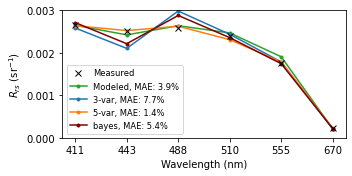

In [21]:
plt.figure(figsize=(5,2.5))
plt.plot(all_rrs[:,ex_ind],marker='x',label='Measured',c='k',ls='none',zorder=999)
plt.plot(der_rrs[:,ex_ind],marker='.',label='Modeled, MAE: %.1f%%'%MAE_all[ex_ind],c='C2')
plt.plot(giop_out_all[ex_ind][6],marker='.',label='3-var, MAE: %.1f%%'%MAE_giop_all[ex_ind],c='C0')
plt.plot(giop2_out_all[ex_ind][6],marker='.',label='5-var, MAE: %.1f%%'%MAE_giop2_all[ex_ind],c='C1')
plt.plot(bayes_out_all[ex_ind][6],marker='.',label='bayes, MAE: %.1f%%'%MAE_bayes_all[ex_ind],c='maroon')

plt.legend(fontsize='small')
plt.xticks(range(len(wvs)),wvs);
plt.xlabel('Wavelength (nm)')
plt.ylabel('$R_{rs}$ (sr$^{-1}$)')
plt.tight_layout()
plt.ylim([0,0.003])
plt.yticks([0,0.001,0.002,0.003]);

#plt.savefig('rrs_ex.png',dpi=300,transparent=True)

In [22]:
def make_gaussian(x,mean,dev):
    return np.exp(-(x-mean)**2/(2*dev**2))/np.sqrt(2*np.pi*dev**2)

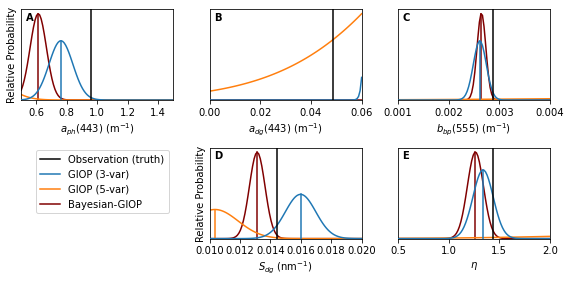

In [23]:
truths = (all_aph[1,ex_ind]/.055,all_adg[1,ex_ind],all_bbp[1,ex_ind],all_sdg[ex_ind],all_eta[ex_ind])
ranges = ([.5,1.5],[0,.06],[0.001,0.004],[0.01,0.02],[0.5,2])
fig,ax = plt.subplots(2,3,figsize=(8,4))
ax[1,0].set_visible(False)
ax = (ax[0,0],ax[0,1],ax[0,2],ax[1,1],ax[1,2])

# need to make the 3-var solution because the output has eta and Sdg in different places (because they aren't retrieved)
example_3var_sol = np.concatenate((giop_out_all[ex_ind][0],[giop_out_all[ex_ind][4]],[giop_out_all[ex_ind][5]]))
example_3var_covar = np.zeros(shape=(5,5))
example_3var_covar[0:3,0:3] = giop_out_all[ex_ind][1]
example_3var_covar[3,3] = 0.001**2
example_3var_covar[4,4] = 0.1**2

for i,a in enumerate(ax):
    # plot truth as vertical line
    a.axvline(truths[i],c='k',label='Observation (truth)',zorder=4)
    
    # set x var
    xx = np.linspace(ranges[i][0],ranges[i][1],100)
    
    # plot 3-var GIOP distribution and most-likely value
    g = make_gaussian(xx,example_3var_sol[i],example_3var_covar[i,i]**.5)
    a.plot(xx,g,c='C0',label='GIOP (3-var)',zorder=3)
    a.plot(example_3var_sol[[i,i]],[0,np.max(g)],c='C0',zorder=3)
    
    # plot 5-var GIOP distribution and most-likely value
    g = make_gaussian(xx,giop2_out_all[ex_ind][0][i],giop2_out_all[ex_ind][1][i,i]**.5)
    a.plot(xx,g,c='C1',label='GIOP (5-var)',zorder=2)
    a.plot(giop2_out_all[ex_ind][0][[i,i]],[0,np.max(g)],c='C1',zorder=2)
    
    # plot Bayes GIOP distribution and most-likely value
    g = make_gaussian(xx,bayes_out_all[ex_ind][0][i],bayes_out_all[ex_ind][7][i,i]**.5)
    a.plot(xx,g,c='maroon',label='Bayesian-GIOP',zorder=0)
    a.plot(bayes_out_all[ex_ind][0][[i,i]],[0,np.max(g)],c='maroon',zorder=0)
    
    a.set_xlim(ranges[i])
    a.set_ylim([0,None])
    a.set_yticks([])
for a,label in zip(ax,['$a_{ph}(443)$ (m$^{-1}$)','$a_{dg}(443)$ (m$^{-1}$)','$b_{bp}(555)$ (m$^{-1}$)','$S_{dg}$ (nm$^{-1}$)','$\eta$']):
    a.set_xlabel(label);
plt.tight_layout()
ax[0].legend(loc=(0.1,-1.25))
ax[0].set_ylabel('Relative Probability')
ax[3].set_ylabel('Relative Probability')
for a,letter in zip(ax,['A','B','C','D','E']):
    a.annotate(letter,(0.03,0.88),xycoords='axes fraction',fontweight='bold')
#plt.savefig('result_ex.png',dpi=300)

In [24]:
print(' \t\t Truth \t pygiop \t Bayes \t\t pygiop (5var)')
print('a_ph(443) \t %.2f \t %.2f (%.2f)\t %.2f (%.2f)\t %.2f (%.2f)'%
      (all_aph[1,ex_ind]/.055, giop_out_all[ex_ind][0][0], (giop_out_all[ex_ind][1][0,0])**.5, bayes_out_all[ex_ind][0][0], (bayes_out_all[ex_ind][7][0,0])**.5, giop2_out_all[ex_ind][0][0], (giop2_out_all[ex_ind][1][0,0])**.5))
print('a_dg(443) \t %.3f \t %.3f (%.3f)\t %.3f (%.3f)\t %.3f (%.3f)'%
      (all_adg[1,ex_ind], giop_out_all[ex_ind][0][1], giop_out_all[ex_ind][1][1,1]**.5, bayes_out_all[ex_ind][0][1], bayes_out_all[ex_ind][7][1,1]**.5, giop2_out_all[ex_ind][0][1], giop2_out_all[ex_ind][1][1,1]**.5))
print('b_bp(443) \t %.4f\t %.4f (%.4f) %.4f (%.4f) %.4f (%.4f)'%
      (all_bbp[1,ex_ind], giop_out_all[ex_ind][0][2], giop_out_all[ex_ind][1][2,2]**.5, bayes_out_all[ex_ind][0][2], bayes_out_all[ex_ind][7][2,2]**.5, giop2_out_all[ex_ind][0][2], giop2_out_all[ex_ind][1][2,2]**.5))
print('   S_dg   \t %.3f \t %.3f \t\t %.3f (%.3f)\t %.3f (%.3f)'%
      (all_sdg[ex_ind], giop_out_all[ex_ind][4], bayes_out_all[ex_ind][0][3], bayes_out_all[ex_ind][7][3,3]**.5, giop2_out_all[ex_ind][0][3], giop2_out_all[ex_ind][1][3,3]**.5))
print('    eta   \t %.2f \t %.2f \t\t %.2f  (%.2f)\t %.2f  (%.2f)'%
      (all_eta[ex_ind], giop_out_all[ex_ind][5], bayes_out_all[ex_ind][0][4], bayes_out_all[ex_ind][7][4,4]**.5, giop2_out_all[ex_ind][0][4], giop2_out_all[ex_ind][1][4,4]**.5))

 		 Truth 	 pygiop 	 Bayes 		 pygiop (5var)
a_ph(443) 	 0.96 	 0.76 (0.08)	 0.61 (0.05)	 0.23 (0.14)
a_dg(443) 	 0.049 	 0.069 (0.002)	 0.072 (0.002)	 0.176 (0.062)
b_bp(443) 	 0.0029	 0.0026 (0.0001) 0.0026 (0.0001) 0.0076 (0.0032)
   S_dg   	 0.014 	 0.016 		 0.013 (0.001)	 0.010 (0.002)
    eta   	 1.44 	 1.34 		 1.26  (0.08)	 3.68  (1.26)


38 retrievals (out of 86) have higher MAE than 25%


Text(0.5, 0, 'Retrieval number (sorted)')

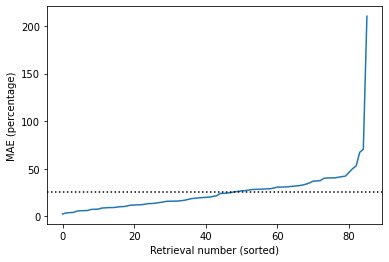

In [26]:
print(np.sum(MAE_all>25),'retrievals (out of %d) have higher MAE than 25%%'%len(all_idx))
plt.plot(np.sort(MAE_all))
plt.axhline(25,c='k',ls=':');
plt.ylabel('MAE (percentage)')
plt.xlabel('Retrieval number (sorted)')

In [27]:
print(np.nanpercentile(MAE_giop_all,[25,50,75]))
print(np.nanmean(MAE_giop_all),np.nanstd(MAE_giop_all))
print(np.nanmean(MAE_bayes_all),np.nanstd(MAE_bayes_all))
print(np.nanmean(MAE_giop2_all),np.nanstd(MAE_giop2_all))

[ 6.83572432  8.25190942 10.51130509]
8.72141264426521 2.555647959770185
7.629724836404267 2.3713958447175165
1.420236224999945 0.6988155059348982


## Bunches of NOMAD stats

/var/folders/qy/wmwmmxjn49vdd0lrh2vp44sm0002np/T/ipykernel_12211/2709724868.py:12: RuntimeWarning: invalid value encountered in log
  ax[0].plot(centers,np.histogram(np.log(giop2_out_vals[:,0]/(all_aph[1]/.055)),edges)[0],c='C1',label='GIOP (5-var)',**kwargs)


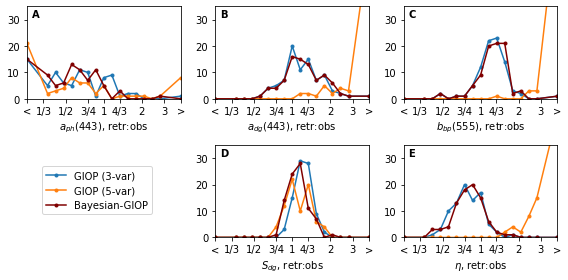

In [50]:
fig,ax = plt.subplots(2,3,figsize=(8,4))
ax[1,0].set_visible(False)
ax = (ax[0,0],ax[0,1],ax[0,2],ax[1,1],ax[1,2])

kwargs = {'marker':'.','clip_on':True}

edges = np.linspace(np.log(1/3),np.log(3),16); centers = edges[:-1]+np.diff(edges)/2
edges = np.concatenate(([-np.inf],edges,[np.inf]))
centers = np.concatenate(([-1.4],centers,[1.4]))

ax[0].plot(centers,np.histogram(np.log(giop_out_vals[:,0]/(all_aph[1]/.055)),edges)[0],c='C0',label='GIOP (3-var)',**kwargs)
ax[0].plot(centers,np.histogram(np.log(giop2_out_vals[:,0]/(all_aph[1]/.055)),edges)[0],c='C1',label='GIOP (5-var)',**kwargs)
ax[0].plot(centers,np.histogram(np.log(bayes_out_vals[:,0]/(all_aph[1]/.055)),edges)[0],c='maroon',label='Bayesian-GIOP',**kwargs)

ax[1].plot(centers,np.histogram(np.log(giop_out_vals[:,1]/all_adg[1]),edges)[0],c='C0',label='GIOP (3-var)',**kwargs)
ax[1].plot(centers,np.histogram(np.log(giop2_out_vals[:,1]/all_adg[1]),edges)[0],c='C1',label='GIOP (5-var)',**kwargs)
ax[1].plot(centers,np.histogram(np.log(bayes_out_vals[:,1]/all_adg[1]),edges)[0],c='maroon',label='Bayesian-GIOP',**kwargs)

ax[2].plot(centers,np.histogram(np.log(giop_out_vals[:,2]/all_bbp[4]),edges)[0],c='C0',label='GIOP (3-var)',**kwargs)
ax[2].plot(centers,np.histogram(np.log(giop2_out_vals[:,2]/all_bbp[4]),edges)[0],c='C1',label='GIOP (5-var)',**kwargs)
ax[2].plot(centers,np.histogram(np.log(bayes_out_vals[:,2]/all_bbp[4]),edges)[0],c='maroon',label='Bayesian-GIOP',**kwargs)

ax[3].plot(centers,np.histogram(np.log(giop_out_sdg/all_sdg),edges)[0],c='C0',label='GIOP (3-var)',**kwargs)
ax[3].plot(centers,np.histogram(np.log(giop2_out_vals[:,3]/all_sdg),edges)[0],c='C1',label='GIOP (5-var)',**kwargs)
ax[3].plot(centers,np.histogram(np.log(bayes_out_vals[:,3]/all_sdg),edges)[0],c='maroon',label='Bayesian-GIOP',**kwargs)

ax[4].plot(centers,np.histogram(np.log(giop_out_eta/all_eta),edges)[0],c='C0',label='GIOP (3-var)',**kwargs)
ax[4].plot(centers,np.histogram(np.log(giop2_out_vals[:,4]/all_eta),edges)[0],c='C1',label='GIOP (5-var)',**kwargs)
ax[4].plot(centers,np.histogram(np.log(bayes_out_vals[:,4]/all_eta),edges)[0],c='maroon',label='Bayesian-GIOP',**kwargs)

for a in ax:
    a.set_xticks(np.log([np.exp(-1.4),1/3,.5,3/4,1,4/3,2,3,np.exp(1.4)]))
    a.set_xticklabels(['<','1/3','1/2','3/4',1,'4/3','2','3','>'],fontsize='10')
    a.set_ylim([0,35])
    a.set_xlim([-1.4,1.4])

for a,label in zip(ax,['$a_{ph}(443)$','$a_{dg}(443)$','$b_{bp}(555)$','$S_{dg}$','$\eta$']):
    a.set_xlabel(label+', retr:obs');
plt.tight_layout()
ax[0].legend(loc=(0.1,-1.25))
for a,letter in zip(ax,['A','B','C','D','E']):
    a.annotate(letter,(0.03,0.88),xycoords='axes fraction',fontweight='bold')
#plt.savefig('results_all.png',dpi=300)

### a_ph

In [29]:
print('3-variable stats')
print('Bias factor',np.exp(np.nanmean(np.log(giop_out_vals[:,0])-np.log(all_aph[1]/.055))))
print('MAE',np.exp(np.nanmean(np.abs(np.log(giop_out_vals[:,0])-np.log(all_aph[1]/.055)))))
print('% wins (1)',np.sum(np.abs(giop_out_vals[:,0]-all_aph[1]/.055)<np.abs(bayes_out_vals[:,0]-all_aph[1]/.055))/np.sum(np.isfinite(giop_out_vals[:,0]*bayes_out_vals[:,0])))
print('% wins (2)',np.sum(np.abs(giop_out_vals[:,0]-all_aph[1]/.055)<np.abs(giop2_out_vals[:,0]-all_aph[1]/.055))/np.sum(np.isfinite(giop_out_vals[:,0]*giop2_out_vals[:,0])))
print('% wins',(0.20930+0.64935)/2)

3-variable stats
Bias factor 0.5825911433140485
MAE 1.9224874175675237
% wins (1) 0.627906976744186
% wins (2) 0.7307692307692307
% wins 0.429325


In [30]:
print('bayesian stats')
print('Bias factor',np.exp(np.nanmean(np.log(bayes_out_vals[:,0])-np.log(all_aph[1]/.055))))
print('MAE',np.exp(np.nanmean(np.abs(np.log(bayes_out_vals[:,0])-np.log(all_aph[1]/.055)))))
print('% wins (1)',np.sum(np.abs(bayes_out_vals[:,0]-all_aph[1]/.055)<np.abs(giop_out_vals[:,0]-all_aph[1]/.055))/np.sum(np.isfinite(bayes_out_vals[:,0]*giop_out_vals[:,0])))
print('% wins (2)',np.sum(np.abs(bayes_out_vals[:,0]-all_aph[1]/.055)<np.abs(giop2_out_vals[:,0]-all_aph[1]/.055))/np.sum(np.isfinite(bayes_out_vals[:,0]*giop2_out_vals[:,0])))
print('% wins',(0.79070+0.70130)/2)

bayesian stats
Bias factor 0.5347889560164392
MAE 1.954400692832507
% wins (1) 0.37209302325581395
% wins (2) 0.6923076923076923
% wins 0.746


In [31]:
print('5-variable stats')
print('Bias factor',np.exp(np.nanmean(np.log(giop2_out_vals[:,0])-np.log(all_aph[1]/.055))))
print('MAE',np.exp(np.nanmean(np.abs(np.log(giop2_out_vals[:,0])-np.log(all_aph[1]/.055)))))
print('% wins (1)',np.sum(np.abs(giop2_out_vals[:,0]-all_aph[1]/.055)<np.abs(giop_out_vals[:,0]-all_aph[1]/.055))/np.sum(np.isfinite(giop2_out_vals[:,0]*giop_out_vals[:,0])))
print('% wins (2)',np.sum(np.abs(giop2_out_vals[:,0]-all_aph[1]/.055)<np.abs(bayes_out_vals[:,0]-all_aph[1]/.055))/np.sum(np.isfinite(giop2_out_vals[:,0]*bayes_out_vals[:,0])))
print('% wins',(0.35065+0.29870)/2)

5-variable stats
Bias factor 0.48358006745877835
MAE 3.405333300896411
% wins (1) 0.2692307692307692
% wins (2) 0.3076923076923077
% wins 0.32467500000000005


/var/folders/qy/wmwmmxjn49vdd0lrh2vp44sm0002np/T/ipykernel_12211/465673257.py:2: RuntimeWarning: invalid value encountered in log
  print('Bias factor',np.exp(np.nanmean(np.log(giop2_out_vals[:,0])-np.log(all_aph[1]/.055))))
/var/folders/qy/wmwmmxjn49vdd0lrh2vp44sm0002np/T/ipykernel_12211/465673257.py:3: RuntimeWarning: invalid value encountered in log
  print('MAE',np.exp(np.nanmean(np.abs(np.log(giop2_out_vals[:,0])-np.log(all_aph[1]/.055)))))


### a_dg

In [32]:
print('3-variable stats')
print('Bias factor',np.exp(np.nanmean(np.log(giop_out_vals[:,1])-np.log(all_adg[1]))))
print('MAE',np.exp(np.nanmean(np.abs(np.log(giop_out_vals[:,1])-np.log(all_adg[1])))))
print('% wins (1)',np.sum(np.abs(giop_out_vals[:,1]-all_adg[1])<np.abs(bayes_out_vals[:,1]-all_adg[1]))/np.sum(np.isfinite(giop_out_vals[:,1]*bayes_out_vals[:,1])))
print('% wins (2)',np.sum(np.abs(giop_out_vals[:,1]-all_adg[1])<np.abs(giop2_out_vals[:,1]-all_adg[1]))/np.sum(np.isfinite(giop_out_vals[:,1]*giop2_out_vals[:,1])))
print('% wins',(0.65116+0.92208)/2)

3-variable stats
Bias factor 1.1974772486320615
MAE 1.3517993992393031
% wins (1) 0.7093023255813954
% wins (2) 0.9615384615384616
% wins 0.78662


In [33]:
print('bayesian stats')
print('Bias factor',np.exp(np.nanmean(np.log(bayes_out_vals[:,1])-np.log(all_adg[1]))))
print('MAE',np.exp(np.nanmean(np.abs(np.log(bayes_out_vals[:,1])-np.log(all_adg[1])))))
print('% wins (1)',np.sum(np.abs(bayes_out_vals[:,1]-all_adg[1])<np.abs(giop_out_vals[:,1]-all_adg[1]))/np.sum(np.isfinite(bayes_out_vals[:,1]*giop_out_vals[:,1])))
print('% wins (2)',np.sum(np.abs(bayes_out_vals[:,1]-all_adg[1])<np.abs(giop2_out_vals[:,1]-all_adg[1]))/np.sum(np.isfinite(bayes_out_vals[:,1]*giop2_out_vals[:,1])))
print('% wins',(0.34884+0.90909)/2)

bayesian stats
Bias factor 1.238711644022501
MAE 1.3840645049746263
% wins (1) 0.29069767441860467
% wins (2) 0.9615384615384616
% wins 0.628965


In [34]:
print('5-variable stats')
print('Bias factor',np.exp(np.nanmean(np.log(giop2_out_vals[:,1])-np.log(all_adg[1]))))
print('MAE',np.exp(np.nanmean(np.abs(np.log(giop2_out_vals[:,1])-np.log(all_adg[1])))))
print('% wins (1)',np.sum(np.abs(giop2_out_vals[:,1]-all_adg[1])<np.abs(giop_out_vals[:,1]-all_adg[1]))/np.sum(np.isfinite(giop2_out_vals[:,1]*giop_out_vals[:,1])))
print('% wins (2)',np.sum(np.abs(giop2_out_vals[:,1]-all_adg[1])<np.abs(bayes_out_vals[:,1]-all_adg[1]))/np.sum(np.isfinite(giop2_out_vals[:,1]*bayes_out_vals[:,1])))
print('% wins',(0.07792+0.09091)/2)

5-variable stats
Bias factor 5.803611745396867
MAE 5.803611745396867
% wins (1) 0.038461538461538464
% wins (2) 0.038461538461538464
% wins 0.084415


### b_bp

In [35]:
print('3-variable stats')
print('Bias factor',np.exp(np.nanmean(np.log(giop_out_vals[:,2])-np.log(all_bbp[4]))))
print('MAE',np.exp(np.nanmean(np.abs(np.log(giop_out_vals[:,2])-np.log(all_bbp[4])))))
print('% wins (1)',np.sum(np.abs(giop_out_vals[:,2]-all_bbp[4])<np.abs(bayes_out_vals[:,2]-all_bbp[4]))/np.sum(np.isfinite(giop_out_vals[:,2]*bayes_out_vals[:,2])))
print('% wins (2)',np.sum(np.abs(giop_out_vals[:,2]-all_bbp[4])<np.abs(giop2_out_vals[:,2]-all_bbp[4]))/np.sum(np.isfinite(giop_out_vals[:,2]*giop2_out_vals[:,2])))
print('% wins',(0.70930+0.77922)/2)

3-variable stats
Bias factor 1.2434371109251632
MAE 1.3371596711175688
% wins (1) 0.872093023255814
% wins (2) 0.9871794871794872
% wins 0.74426


In [36]:
print('bayesian stats')
print('Bias factor',np.exp(np.nanmean(np.log(bayes_out_vals[:,2])-np.log(all_bbp[4]))))
print('MAE',np.exp(np.nanmean(np.abs(np.log(bayes_out_vals[:,2])-np.log(all_bbp[4])))))
print('% wins (1)',np.sum(np.abs(bayes_out_vals[:,2]-all_bbp[4])<np.abs(giop_out_vals[:,2]-all_bbp[4]))/np.sum(np.isfinite(bayes_out_vals[:,2]*giop_out_vals[:,2])))
print('% wins (2)',np.sum(np.abs(bayes_out_vals[:,2]-all_bbp[4])<np.abs(giop2_out_vals[:,2]-all_bbp[4]))/np.sum(np.isfinite(bayes_out_vals[:,2]*giop2_out_vals[:,2])))
print('% wins',(0.29070+0.76623)/2)

bayesian stats
Bias factor 1.2713168765356486
MAE 1.3600777458867035
% wins (1) 0.12790697674418605
% wins (2) 0.9871794871794872
% wins 0.528465


In [37]:
print('5-variable stats')
print('Bias factor',np.exp(np.nanmean(np.log(giop2_out_vals[:,2])-np.log(all_bbp[4]))))
print('MAE',np.exp(np.nanmean(np.abs(np.log(giop2_out_vals[:,2])-np.log(all_bbp[4])))))
print('% wins (1)',np.sum(np.abs(giop2_out_vals[:,2]-all_bbp[4])<np.abs(giop_out_vals[:,2]-all_bbp[4]))/np.sum(np.isfinite(giop2_out_vals[:,2]*giop_out_vals[:,2])))
print('% wins (2)',np.sum(np.abs(giop2_out_vals[:,2]-all_bbp[4])<np.abs(bayes_out_vals[:,2]-all_bbp[4]))/np.sum(np.isfinite(giop2_out_vals[:,2]*bayes_out_vals[:,2])))
print('% wins',(0.22078+0.23377)/2)

5-variable stats
Bias factor 7.532068498326611
MAE 7.532068498326611
% wins (1) 0.01282051282051282
% wins (2) 0.01282051282051282
% wins 0.227275


### S_dg

In [38]:
print('3-variable stats')
print('Bias factor',np.exp(np.nanmean(np.log(giop_out_sdg)-np.log(all_sdg))))
print('MAE',np.exp(np.nanmean(np.abs(np.log(giop_out_sdg)-np.log(all_sdg)))))
print('% wins (1)',np.sum(np.abs(giop_out_sdg-all_sdg)<np.abs(bayes_out_vals[:,3]-all_sdg))/np.sum(np.isfinite(giop_out_sdg*bayes_out_vals[:,3])))
print('% wins (2)',np.sum(np.abs(giop_out_sdg-all_sdg)<np.abs(giop2_out_vals[:,3]-all_sdg))/np.sum(np.isfinite(giop_out_sdg*giop2_out_vals[:,3])))
print('% wins',(0.72093+0.94805)/2)

3-variable stats
Bias factor 1.2126052018508082
MAE 1.2324594751458025
% wins (1) 0.3023255813953488
% wins (2) 0.3717948717948718
% wins 0.83449


In [39]:
print('bayesian stats')
print('Bias factor',np.exp(np.nanmean(np.log(bayes_out_vals[:,3])-np.log(all_sdg))))
print('MAE',np.exp(np.nanmean(np.abs(np.log(bayes_out_vals[:,3])-np.log(all_sdg)))))
print('% wins (1)',np.sum(np.abs(bayes_out_vals[:,3]-all_sdg)<np.abs(giop_out_sdg-all_sdg))/np.sum(np.isfinite(bayes_out_vals[:,3]*giop_out_sdg)))
print('% wins (2)',np.sum(np.abs(bayes_out_vals[:,3]-all_sdg)<np.abs(giop2_out_vals[:,3]-all_sdg))/np.sum(np.isfinite(bayes_out_vals[:,3]*giop2_out_vals[:,3])))
print('% wins',(0.27907+0.94805)/2)

bayesian stats
Bias factor 1.0986932795573843
MAE 1.1725676955128916
% wins (1) 0.6976744186046512
% wins (2) 0.48717948717948717
% wins 0.61356


In [40]:
print('5-variable stats')
print('Bias factor',np.exp(np.nanmean(np.log(giop2_out_vals[:,3])-np.log(all_sdg))))
print('MAE',np.exp(np.nanmean(np.abs(np.log(giop2_out_vals[:,3])-np.log(all_sdg)))))
print('% wins (1)',np.sum(np.abs(giop2_out_vals[:,3]-all_sdg)<np.abs(giop_out_sdg-all_sdg))/np.sum(np.isfinite(giop2_out_vals[:,3]*giop_out_sdg)))
print('% wins (2)',np.sum(np.abs(giop2_out_vals[:,3]-all_sdg)<np.abs(bayes_out_vals[:,3]-all_sdg))/np.sum(np.isfinite(giop2_out_vals[:,3]*bayes_out_vals[:,3])))
print('% wins',(0.05195+0.05195)/2)

5-variable stats
Bias factor 1.128371040590384
MAE 1.2296794225125356
% wins (1) 0.6282051282051282
% wins (2) 0.5128205128205128
% wins 0.05195


### eta

In [41]:
print('3-variable stats')
print('Bias factor',np.exp(np.nanmean(np.log(giop_out_eta)-np.log(all_eta))))
print('MAE',np.exp(np.nanmean(np.abs(np.log(giop_out_eta)-np.log(all_eta)))))
print('% wins (1)',np.sum(np.abs(giop_out_eta-all_eta)<np.abs(bayes_out_vals[:,4]-all_eta))/np.sum(np.isfinite(giop_out_eta*bayes_out_vals[:,4])))
print('% wins (2)',np.sum(np.abs(giop_out_eta-all_eta)<np.abs(giop2_out_vals[:,4]-all_eta))/np.sum(np.isfinite(giop_out_eta*giop2_out_vals[:,4])))
print('% wins',(0.43023+0.76623)/2)

3-variable stats
Bias factor 0.7900544885701097
MAE 1.3282746229496738
% wins (1) 0.47674418604651164
% wins (2) 1.0
% wins 0.59823


In [42]:
print('bayesian stats')
print('Bias factor',np.exp(np.nanmean(np.log(bayes_out_vals[:,4])-np.log(all_eta))))
print('MAE',np.exp(np.nanmean(np.abs(np.log(bayes_out_vals[:,4])-np.log(all_eta)))))
print('% wins (1)',np.sum(np.abs(bayes_out_vals[:,4]-all_eta)<np.abs(giop_out_eta-all_eta))/np.sum(np.isfinite(bayes_out_vals[:,4]*giop_out_eta)))
print('% wins (2)',np.sum(np.abs(bayes_out_vals[:,4]-all_eta)<np.abs(giop2_out_vals[:,4]-all_eta))/np.sum(np.isfinite(bayes_out_vals[:,4]*giop2_out_vals[:,4])))
print('% wins',(0.56977+0.79221)/2)

bayesian stats
Bias factor 0.8072720711141443
MAE 1.3198570734963075
% wins (1) 0.5232558139534884
% wins (2) 1.0
% wins 0.68099


In [43]:
print('5-variable stats')
print('Bias factor',np.exp(np.nanmean(np.log(giop2_out_vals[:,4])-np.log(all_eta))))
print('MAE',np.exp(np.nanmean(np.abs(np.log(giop2_out_vals[:,4])-np.log(all_eta)))))
print('% wins (1)',np.sum(np.abs(giop2_out_vals[:,4]-all_eta)<np.abs(giop_out_eta-all_eta))/np.sum(np.isfinite(giop2_out_vals[:,4]*giop_out_eta)))
print('% wins (2)',np.sum(np.abs(giop2_out_vals[:,4]-all_eta)<np.abs(bayes_out_vals[:,4]-all_eta))/np.sum(np.isfinite(giop2_out_vals[:,4]*bayes_out_vals[:,4])))
print('% wins',(0.23377+0.20779)/2)

5-variable stats
Bias factor 3.5064078356706596
MAE 3.5064078356706596
% wins (1) 0.0
% wins (2) 0.0
% wins 0.22078
